Synopsis:

Previously, We had been using polarization_f.py to calculate falpha and fbeta (Zack's terms). This time, however, we use Zack's getevec() function to calculate falpha and fbeta. The procedure is as follows.

1. Find the observer screen coordinates alpha and beta of the direct image (n=0) using lensingbands.py. 

2. Use raytracing.py to find the corresponding emission radius r, phi angle, and sign. 

3. Create a mask that selects for the elements in r that are around a constant emission radius (6 or 8 or 10)

4. Apply this mask to phi, sign, alpha, and beta.

5. Create an enumerate loop that loops through all the elements of this new r array (constant emission radius), and uses Zack's getevec() function to calculate Q and U. 

Essentially, the difference between Zack's code and ours is that we use AART to map points on the observer plane to points on the source plane, wheareas Zack uses a different method that involves impact parameters and is a forward-tracing algorithm. 



In [52]:
# import the aart libraries
from aart_func import *
from params import *
from tqdm import tqdm

#print black hole spin and inclination angle to check
print(spin_case)
print(i_case)

0.02
70


In [49]:
# The exact formula for the matrix can be found in Appendix A equation A1 in Zack's paper (Zachary Gelles, Polarized Image of Equatorial Emission in the Kerr Geometry, 2021)
# quantities like delta, xi, and omega_zamo are found in equation 2 of Zack's paper.
def zamo_transform_matrix(rs):
    entry1_1 = (1/rs) * np.sqrt(xi/delta)
    entry1_3 = (omega_zamo / rs) * np.sqrt(xi/delta)
    entry2_2 = np.sqrt(delta) / rs
    entry3_3 = rs / (np.sqrt(xi))
    entry4_4 = - (1/rs)
    return np.array([[entry1_1, 0, 0, entry1_3], [0, entry2_2, 0, 0], [0, 0, 0, entry3_3], [0, 0, entry4_4, 0]])

In [50]:
# Zack's paper Appendix A equation A3
def boost_transform_matrix(rs):
    beta_f = -((spin_case**2 - 2 * np.abs(spin_case) * np.sqrt(rs) + rs**2) / (np.sqrt(spin_case**2 + rs * (rs -2)) * (np.abs(spin_case) + rs**1.5)))
    """Why did Zack put the negative boost here?"""
    # beta = 1 / np.sqrt(rs - 2)
    kai = - np.pi/2
    gamma = 1/(np.sqrt(1-beta_f**2))
    bentry1_1 = gamma
    bentry1_2 = -beta_f*gamma*np.cos(kai)
    bentry1_3 = -beta_f*gamma*np.sin(kai)
    bentry2_1 = bentry1_2
    bentry2_2 = (gamma-1) * (np.cos(kai))**2 + 1
    bentry2_3 = (gamma-1) * np.cos(kai) * np.sin(kai)
    bentry3_1 = bentry1_3 
    bentry3_2 = bentry2_3
    bentry3_3 = (gamma-1) * (np.sin(kai))**2 + 1
    boost_transform_matrix = np.array ([[bentry1_1, bentry1_2, bentry1_3, 0], [bentry2_1, bentry2_2, bentry2_3, 0], [bentry3_1, bentry3_2, bentry3_3, 0], [0, 0, 0, 1] ])
    return boost_transform_matrix

In [51]:
# next, we build the overall coordinate transform from the local frame to the observer frame
def coordtransform(rs): 
    minkmetric = np.diag([-1, 1, 1, 1])
    coordtransform = np.matmul(np.matmul(minkmetric, boost_transform_matrix(rs)), zamo_transform_matrix(rs))
    return coordtransform

# and we also find its inverse
def coordtransforminverse(rs):
    return np.transpose(np.matmul(boost_transform_matrix(rs), zamo_transform_matrix(rs)))

"""Why is the transpose the inverse? Orthogonal matrix? What if I just used np.linalg.inv()? Also, why is the lorentz transformation matrix no longer here?"""

'Why is the transpose the inverse? Orthogonal matrix? What if I just used np.linalg.inv()? Also, why is the lorentz transformation matrix no longer here?'

In [33]:
# run lengsingbands.py
%time !python3 lensingbands.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Computing the lensing bands
Number of points in the n=0 grid  36000000
Number of points in the n=1 grid  900
Number of points in the n=2 grid  900
File  ./Results/LensingBands_a_0.02_i_20.h5  created.
CPU times: user 64.3 ms, sys: 61.6 ms, total: 126 ms
Wall time: 22.5 s


In [27]:
# now we read in the results of lensingbands.py
fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])

h5f.close()

# note that, for our purpose (to produce Q and U loops), only the array supergrid0 is relevant. We do no need to use any other arrays. 
# Thus, let's see what supergrid0 looks like.

print(supergrid0.shape)
print(mask0.shape)

Reading file:  ./Results/LensingBands_a_0.02_i_70.h5
(10240000, 2)
(10240000,)


In [28]:
lim0

8

In [29]:
np.sqrt(2*8**2)

11.313708498984761

In [30]:
# run raytracing.py
%time !python3 raytracing.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Ray-tracing
Reading file:  ./Results/LensingBands_a_0.02_i_70.h5
Analytical ray-tracing of the n=0 band points
^C
CPU times: user 20.6 ms, sys: 36.3 ms, total: 56.9 ms
Wall time: 3.93 s


In [31]:
# and now we read in the results of raytracing.py

fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]


h5f.close()

print(rs0.shape)

Reading file:  ./Results/Rays_a_0.02_i_70.h5
(10240000,)


In [32]:
np.nanmax(rs0)

24.607698432583607

In [33]:
# now instead of running polarization.py, we use Zack's paper to build a parallel version of polarization_f.py

# then, specify the local magnetic field, in the order of x, y, z
"""Cartesian?"""

b_array = np.array([0, 0.0, 1])

In [34]:

# first, we extract the alpha and beta coordinates from the parameter "grid". Recall that "grid" is calculated by lensingbands.py.
alpha = supergrid0[:,0][mask0]
beta = supergrid0[:, 1][mask0]

# find the corresponding emmission radius, sign, and phi angle
rs = rs0[mask0]
sign = sign0[mask0]
phi = phi0[mask0]


# then, we find the conserved quantities lam(angular_momentum) and eta(carter constant) using a function from raytracing.py
# Zack's paper, equation 14, but calculated using AART code.
lam, eta = rt.conserved_quantities(alpha, beta, i_case * np.pi/180, spin_case)

# then, we calculate all the quantities defined in equation 2 of Zack's paper
delta = rs**2 - 2*rs + spin_case**2
xi = (rs**2 + spin_case**2)**2 - delta * (spin_case**2) # here, we are taking theta = pi/2. This is a correction from previously where I mistook theta for i_case. 
omega_zamo = (2 * spin_case * rs) / xi
chi = -np.pi/2

# then, we find the radial potential
# Zack's paper equation 10, here using AART function from raytracing.py
v_rad = rt.radial_potential(rs, spin_case, lam, eta)

# in this code block, we select for the elements in all the arrays above that correspond to a specific constant emission radius.

# define the constant emission radius
r = 6

# define the upper and lower bounds
upper = r + 0.0001
lower = r - 0.0001

# construct the mask
mask = (rs < upper) & (rs > lower)


In [35]:
# construct the new rs array
rs_r = rs[mask]

# construct the new phi array
phi_r = phi[mask]

# construct new alpha array
alpha_r = alpha[mask]

# construct the new beta array
beta_r = beta[mask]

# and so on, get the rest of these quantities
lam_r = lam[mask]
eta_r = eta[mask]
delta_r = delta[mask]
xi_r = xi[mask]
omega_zamo_r = omega_zamo[mask]
chi = -np.pi/2 # chi does not change
v_rad_r = v_rad[mask]
sign_r = sign[mask]


In [36]:
# print(rs_r)
# print(phi_r)
# print(sign_r)

%store rs_r
%store phi_r
%store sign_r
%store alpha_r
%store beta_r

Stored 'rs_r' (ndarray)
Stored 'phi_r' (ndarray)
Stored 'sign_r' (ndarray)
Stored 'alpha_r' (ndarray)
Stored 'beta_r' (ndarray)


In [37]:
print(rs_r[0])
print(phi_r[0])
print(alpha_r[0])
print(beta_r[0])
print(sign_r[0])

6.000080232584524
-3.508639296245402
-7.239762425758049
0.9477961863082207
1.0


In [38]:
print(rs_r[1])
print(phi_r[1])
print(alpha_r[1])
print(beta_r[1])

5.9999360633652845
-3.5104017835748715
-7.239762425758049
0.9527977492966553


In [39]:
%store -r zack_sign
%store -r zack_alpha
%store -r zack_beta
print(zack_alpha.shape)
print(zack_beta.shape)


(555,)
(555,)


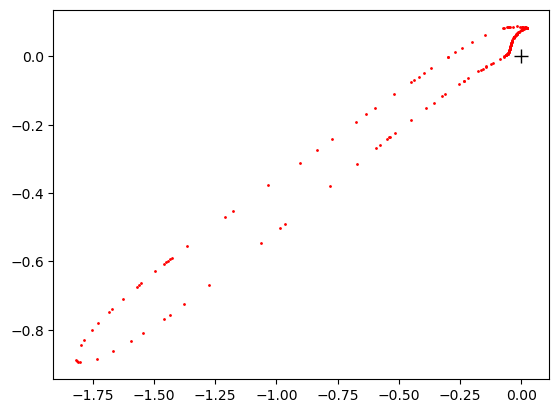

In [48]:
# below here we have to do a gigantic enumerate loop
for i, r in enumerate(rs_r):
    
    # define the individual quantities
    alpha = alpha_r[i]
    beta = beta_r[i]
    lam, eta = rt.conserved_quantities(alpha, beta, i_case * np.pi/180, spin_case)
    
    delta = r**2 - 2*r + spin_case**2
    xi = (r**2 + spin_case**2)**2 - delta * (spin_case**2) # here, we are taking theta = pi/2. This is a correction from previously where I mistook theta for i_case. 
    omega_zamo = (2 * spin_case * r) / xi
    chi = -np.pi/2

# then, we find the radial potential
# Zack's paper equation 10, here using AART function from raytracing.py
    v_rad = rt.radial_potential(r, spin_case, lam, eta)

    sign = sign_r[i]
    
    # define the lowered momentum in Boyer-Lindquist
    p_lower_t = -1
    p_lower_r = sign * np.sqrt(v_rad) / delta
    """What is the sign of this?"""
    p_lower_theta = - np.sqrt(eta)
    p_lower_phi = lam
    
    p_lower_matrix = np.array([p_lower_t, p_lower_r, p_lower_theta, p_lower_phi])
    
    # transform p_lower_matrix to local frame
    p_local_matrix = np.matmul(coordtransform(r), p_lower_matrix)
    
    """What do these mean in Zack's code?"""
    redshift = 1 / p_local_matrix[0]
    lp = 1
    
    # take the cross product of p_local_matrix and b_array to find the local polarization
    # and then insert 0 as the t coordinate, and normalize it
    # Zack's paper page 5 equation 25
    local_polarization = np.cross(p_local_matrix[1:], b_array)
    local_polarization = np.insert(local_polarization, 0, 0) / np.linalg.norm(p_local_matrix[1:])
    
    # now we transform the local polarization back into Boyer-Lindquist
    upper_polarization = np.matmul(coordtransforminverse(r), local_polarization)
    f_t = upper_polarization[0]
    f_r = upper_polarization[1]
    f_theta = upper_polarization[2]
    f_phi = upper_polarization[3]
    
    # now we calculate the raised momentum in Boyer_Lindquist
    # Zack's paper page 5 equation 24
    p_upper_t = 1 / (r**2) * (-spin_case * (spin_case - lam) + (r**2 + spin_case**2) * (r**2 + spin_case**2 - spin_case * lam) / delta)
    p_upper_r = sign * np.sqrt(v_rad) / r**2
    p_upper_theta = -np.sqrt(eta) / r**2
    p_upper_phi = 1/(r**2) * (-(spin_case -lam) + (spin_case * (r**2 + spin_case**2 - spin_case * lam)) / delta)
    
    # now, we proceed to calculate the Penrose_Walker Constant
    # Zack's paper page 5 equation 29
    AA = (p_upper_t * f_r - p_upper_r * f_t) + spin_case * (p_upper_r * f_phi - p_upper_phi * f_r)
    BB = (r**2 + spin_case**2) * (p_upper_phi * f_theta - p_upper_theta * f_phi) - spin_case * (p_upper_t * f_theta - p_upper_theta * f_t)
    k1 = r * AA
    k2 = -r * BB
    
    
    # calculate falpha and fbeta
    # Zack's paper page 6 equation 31
    nu = -(alpha + spin_case * np.sin(i_case * np.pi/180))
    falpha = (beta * k2 - nu * k1) / (nu**2 + beta**2)
    fbeta = (beta * k1 + nu * k2) / (nu**2 + beta**2)
    
    
    """why is the following step necessary? Where on paper?"""
    falpha *= redshift**2 * np.sqrt(np.abs(lp))
    fbeta *= redshift**2 * np.sqrt(np.abs(lp))
    
    # calculate Q and U
    # Zack's paper 
    Q = fbeta**2 - falpha**2
    U = -2 * falpha * fbeta
    
    plt.scatter(Q, U,s=1,color="r")
   
plt.plot(0,0,"k+",markersize=10)
    
#plt.scatter(alpha, beta, c=redshift**4 * (falpha**2 + fbeta**2) )
    
plt.savefig(f"QUloops/({b_array})_{i_case}_{round(r)}.jpg")

In [29]:
"""What might be the problem?
1. the sign of p_lower_r and p_upper_r.
2. how beta is defined
Other differences from Zach's code?"""

"What might be the problem?\n1. the sign of p_lower_r and p_upper_r.\n2. how beta is defined\nOther differences from Zach's code?"

Next steps:
1. Destructure getevec, use Zack's alpha and beta and sign to see if the same results can be produced. 
2. Gradually switch in AART's alpha and beta and sign to see if the same results can be produced. 